In [1]:
import keras

Using TensorFlow backend.


In [2]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

model = VGG16(weights='imagenet', include_top=False)

img_path = 'elephant.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

features = model.predict(x)

FileNotFoundError: [Errno 2] No such file or directory: 'elephant.jpg'

## Image Augmentation
All of this goes in the Generator Function
1. crop
2. Normalize
2. gaussian blur
3. augmentation: translating, jitter
3. resize
4. augmentation: flip

## Data Generator
We want to generate (and augment) data on the fly

In [232]:
import os
import csv
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

##Function generates batch_size of data from the samples provided
#Input: samples: list of samples from the data .csv
#       batch_size: size of generated data (4th dim)

def generator(samples, batch_size=32):
    correction = 0.2;
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        samples = shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = []
            angles = []
            for batch_sample in batch_samples:
                image_name = batch_sample[0]
                image = cv2.imread(image_name)
                angle = float(batch_sample[3])
                images.append(image)
                angles.append(angle)
                
                #[(left_img_idx, +ve correction), (right_img_idx, -ve correction)]
                for idx, sign in [(1, 1), (2, -1)]:
                    image_name = batch_sample[idx]
                    image = cv2.imread(image_name)
                    images.append(image)
                    angles.append(angle + (sign*correction))
                
            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            X_train, y_train = augment_data(X_train, y_train)
            
            yield sklearn.utils.shuffle(X_train, y_train)


In [291]:
##Function to apply affine transform (translation, rotation and skew), flipping
# Input: imageS: opencv style
#        affine_jitter: jitter limit in pixels 
#Output: returns a list of augmented images
def augment_data(images, angles, affine_jitter=0):
    flip_images, flip_angles = flip_data(images, angles)
    images = np.vstack((images, flip_images));
    angles = np.hstack((angles, flip_angles));
    
    return images, angles

def flip_data(images, angles):
    flip_images = images[:, :, ::-1, :];
    flip_angles = -angles;
    return flip_images, flip_angles
    
    
def jitter(images, angles):
    return

In [356]:
data_dir = '../BehavClone_training';
if not os.path.isdir(data_dir):
    print("data directory doesn't exist")

csv_file = os.path.join(data_dir, 'driving_log.csv')
if not os.path.isfile(csv_file):
    print("Could not find CSV file")

image_dir = os.path.join(data_dir, 'IMG')
if not os.path.isdir(image_dir):
    print("Could not find image directory")
    
samples = []
with open(csv_file) as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

train_samples, validation_samples = train_test_split(samples, test_size=0.2)

In [357]:
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=5)
validation_generator = generator(validation_samples, batch_size=5)

In [358]:
train_batch_X, train_batch_y = next(train_generator)

In [359]:
len(train_batch_X)

30

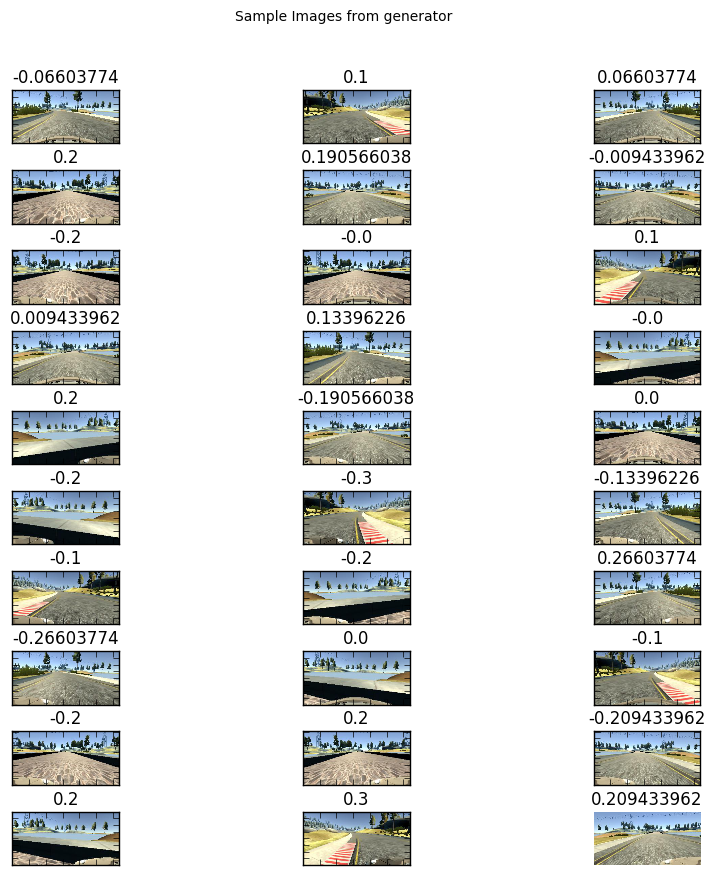

In [334]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(10, 3, hspace = 0.5, wspace=0.5)
plt.figure(figsize=(10,10))

for i in range(len(train_batch_X)):
    ax = plt.subplot(gs[i])
    #ax.tick_params('off')
    ax.imshow(cv2.cvtColor(train_batch_X[i], cv2.COLOR_BGR2RGB))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    title = train_batch_y[i]
    ax.set_title(title)
plt.axis('off')
plt.suptitle("Sample Images from generator")  
plt.show()

In [361]:
#plt.figure(figsize=(10,10))
def plot_image_data(train_batch_X, train_batch_y):
    gs = gridspec.GridSpec(len(train_batch_y)//3, 3, hspace = 0.5, wspace=0)
    plt.figure(figsize=(10, len(train_batch_y)*1.5//3))

    for i in range(len(train_batch_X)):
        ax = plt.subplot(gs[i])
        #ax.tick_params('off')
        ax.imshow(cv2.cvtColor(train_batch_X[i], cv2.COLOR_BGR2RGB))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        title = train_batch_y[i]
        ax.set_title(title)
    plt.axis('off')
    plt.suptitle("Sample Images from generator")  
    plt.show()

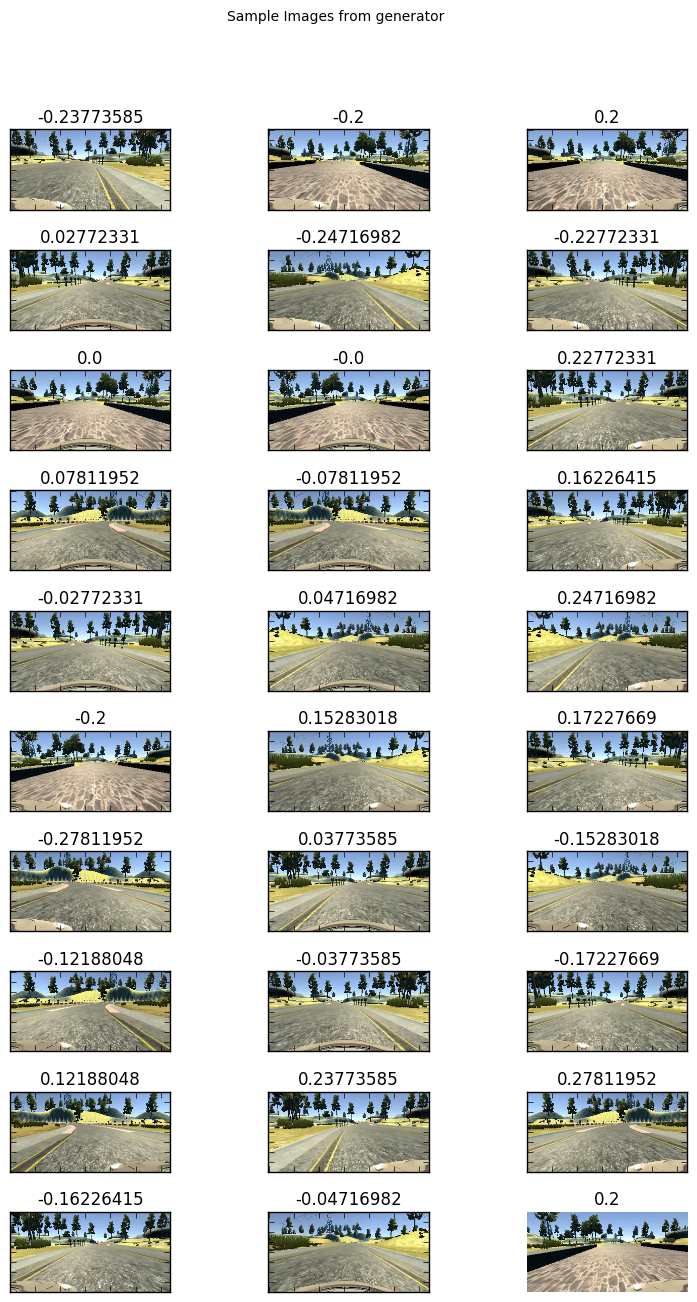

In [362]:
plot_image_data(train_batch_X, train_batch_y)